In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Loading dataset
!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset
#rajatvisitme/skin-cancer-isic

!mkdir -p skin_disease

#  فك الضغط
!unzip skin-diseases-image-dataset.zip -d skin_disease

Streaming output truncated to the last 5000 lines.
  inflating: skin_disease/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-65.jpg  
  inflating: skin_disease/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-66.jpg  
  inflating: skin_disease/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-67.jpg  
  inflating: skin_disease/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-69.jpg  
  inflating: skin_disease/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-7.jpg  
  inflating: skin_disease/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-70.jpg  
  inflating: skin_disease/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-71.jpg  
  inflating: skin_d

In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# General imports
import random
import keras

import shutil

In [3]:
# Define paths
data_path = '/content/skin_disease/IMG_CLASSES'

Class counts: [2055, 7970, 2103, 1257, 3323, 1677, 1702, 1847, 3140, 2079]


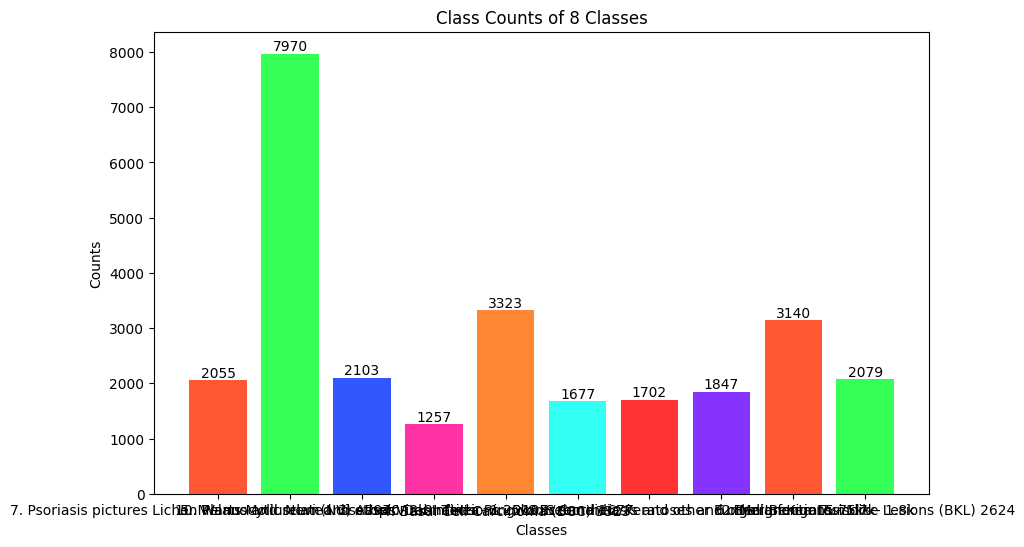

In [4]:
# Use the copied dataset
classes = os.listdir(data_path)
class_counts = [len(os.listdir(data_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

# Oversampling and Undersampling

In [5]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(data_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target

    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []

        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break

        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(data_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [6]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 7000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Processed 7015/7000 images for 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Deleted 970 images for 5. Melanocytic Nevi (NV) - 7970
Processed 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
Processed 7017/7000 images for 3. Atopic Dermatitis - 1.25k
Processed 7003/7000 images for 4. Basal Cell Carcinoma (BCC) 3323
Processed 7021/7000 images for 1. Eczema 1677
Processed 7014/7000 images for 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Processed 7031/7000 images for 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Processed 7012/7000 images for 2. Melanoma 15.75k
Processed 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
Oversampling and undersampling completed successfully.


# Checking class imbalance

Class counts: [6977, 7000, 6997, 6958, 6986, 6975, 6958, 6987, 6983, 6968]


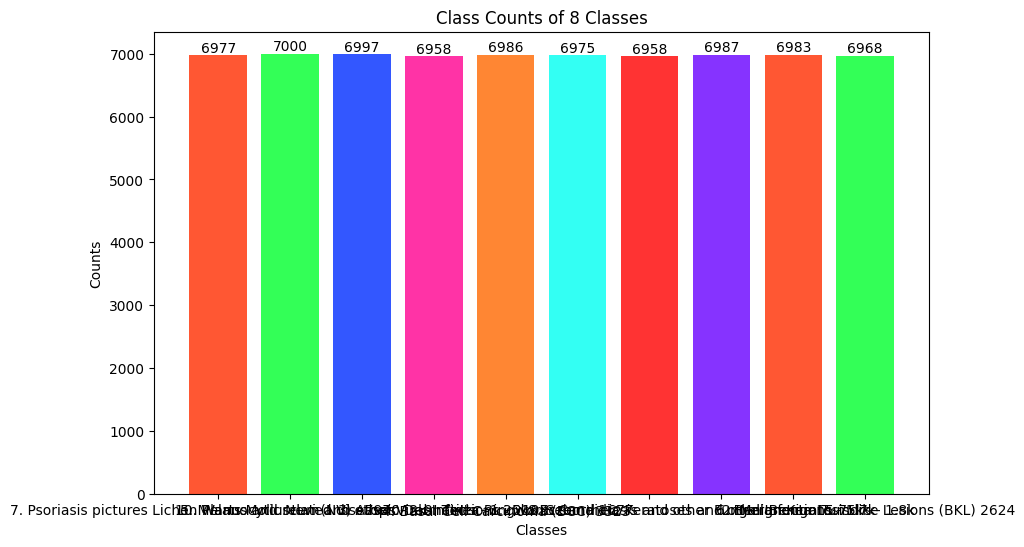

In [7]:
classes = os.listdir(data_path)
class_counts = [len(os.listdir(data_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

# Train and Test Split

In [8]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/content/train'
val_path = '/content/val'
test_path = '/content/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(data_path):  # using the output_path where dataset resides
    class_path = os.path.join(data_path, class_folder)

    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)

    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


# Loading Images

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/content/train'
val_path = '/content/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

# Display class names (optional)
print("Class Names:", class_names)

Found 48847 files belonging to 10 classes.
Found 10464 files belonging to 10 classes.
Class Names: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


# Preprocessing the data

In [10]:
import tensorflow as tf
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

# Model Building

In [11]:
from keras.applications.efficientnet import preprocess_input


# Feature extractor
# Feature extractor using EfficientNetB0
base_model = keras.applications.EfficientNetB0(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x) #output layer
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train the model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6288s 4s/step - accuracy: 0.7044 - loss: 0.8169 - val_accuracy: 0.8665 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6283s 4s/step - accuracy: 0.8596 - loss: 0.3907 - val_accuracy: 0.8688 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6180s 4s/step - accuracy: 0.8782 - loss: 0.3466 - val_accuracy: 0.8814 - val_loss: 0.3230 - learning_rate: 0.0010
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6047s 4s/step - accuracy: 0.8937 - loss: 0.2973 - val_accuracy: 0.8919 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 5/10
  79/1527 ━━━━━━━━━━━━━━━━━━━━ 1:19:03 3s/step - accuracy: 0.9186 - loss: 0.2447

KeyboardInterrupt: 

# Saving the model

In [16]:
model_save_path = '/content/my_model.h5'
model.save(model_save_path)

print(f'Model saved at {model_save_path}')

Model saved at /content/my_model.h5


Found 10478 files belonging to 10 classes.
Classification Report:

                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677       0.90      0.87      0.89      1047
           10. Warts Molluscum and other Viral Infections - 2103       0.88      0.85      0.87      1051
                                              2. Melanoma 15.75k       0.92      0.97      0.94      1048
                                    3. Atopic Dermatitis - 1.25k       0.92      0.87      0.90      1045
                              4. Basal Cell Carcinoma (BCC) 3323       0.95      0.84      0.89      1049
                                 5. Melanocytic Nevi (NV) - 7970       0.90      0.85      0.87      1050
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.82      0.91      0.86      1046
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.81      0.8

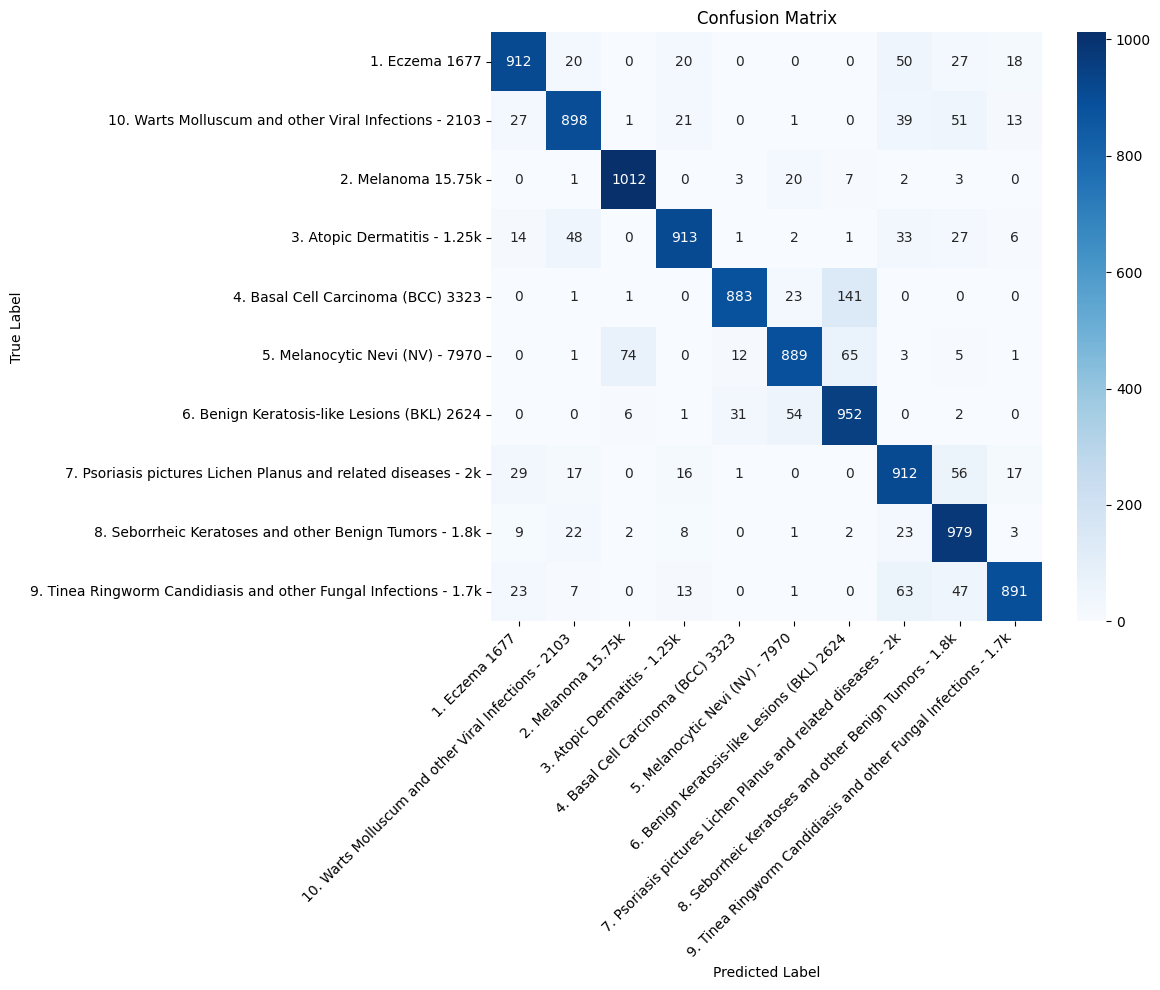

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load test dataset first WITHOUT mapping
raw_test_dataset = image_dataset_from_directory(
    '/content/test',
    image_size=(256, 256),
    batch_size=32,
    shuffle=False  # Critical for matching predictions to labels
)

# Save class names before mapping
class_names = raw_test_dataset.class_names

# Now map and prefetch
test_dataset = raw_test_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

# Predict and gather labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


